# Import Libraries

In [1]:
import functools
import tracemalloc
import psutil
import os
from pathlib import Path
import time

import httpx
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

Matplotlib is building the font cache; this may take a moment.


# Utilities

In [2]:
def profiler(func):
    """Decorator to measure memory usage and execution time of a function."""
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        process = psutil.Process(os.getpid())

        # Start memory + time tracking
        start_mem = process.memory_info().rss / 1024**2
        tracemalloc.start()
        start_time = time.time()

        result = func(*args, **kwargs)  # run target function

        # After execution
        current, peak = tracemalloc.get_traced_memory()
        end_mem = process.memory_info().rss / 1024**2
        end_time = time.time()
        tracemalloc.stop()

        print(f"\n--- Memory Profile for `{func.__name__}` ---")
        print(f"Start memory   : {start_mem:.2f} MB")
        print(f"End memory     : {end_mem:.2f} MB")
        print(f"Peak (tracked) : {peak / 1024**2:.2f} MB")
        print(f"Execution time : {end_time - start_time:.2f} sec")
        print("------------------------------------------\n")

        return result
    return wrapper

In [3]:
# Constants

ROOT_PATH = Path(os.getcwd())
DATASET_URL = "https://drive.usercontent.google.com/download?id=1N1xoxgcw2K3d-49tlchXAWw4wuxLj7EV&export=download"
DATASET_OUTPUT_PATH = ROOT_PATH / "dataset.csv"

In [4]:
# Utilities
@profiler
def download_data(url: str, output_path: Path) -> None:
    with httpx.stream("GET", url) as response:
        response.raise_for_status()  # check for HTTP errors
        with open(output_path, "wb") as f:
            for chunk in response.iter_bytes():
                f.write(chunk)

    print(f"Downloaded to {output_path}")

@profiler
def load_data(file_path: Path, **kwargs) -> pd.DataFrame:
    return pd.read_csv(file_path, **kwargs)

# EDA

## Data Loading

In [5]:
# Data Loading
download_data(DATASET_URL, DATASET_OUTPUT_PATH)

Downloaded to /Users/mf16331x/Temp/Shopee-AI-Engineer-Technical-Test/src/Q1 CSV Parsing/dataset.csv

--- Memory Profile for `download_data` ---
Start memory   : 230.34 MB
End memory     : 235.12 MB
Peak (tracked) : 2.11 MB
Execution time : 4.14 sec
------------------------------------------



In [6]:
# Data Parsing
df = load_data(DATASET_OUTPUT_PATH, index_col=0)


--- Memory Profile for `load_data` ---
Start memory   : 235.14 MB
End memory     : 384.55 MB
Peak (tracked) : 56.11 MB
Execution time : 0.29 sec
------------------------------------------



## Data Understanding

In [7]:
df.shape

(100000, 11)

In [8]:
df.head()

,Customer Id,First Name,Last Name,Company,City,Country,Phone 1,Phone 2,Email,Subscription Date,Website
Index,,,,,,,,,,,
1,ffeCAb7AbcB0f07,Jared,Jarvis,Sanchez-Fletcher,Hatfieldshire,Eritrea,274.188.8773x41185,001-215-760-4642x969,gabriellehartman@benjamin.com,2021-11-11,https://www.mccarthy.info/
2,b687FfC4F1600eC,Marie,Malone,Mckay PLC,Robertsonburgh,Botswana,283-236-9529,(189)129-8356x63741,kstafford@sexton.com,2021-05-14,http://www.reynolds.com/
3,9FF9ACbc69dcF9c,Elijah,Barrera,Marks and Sons,Kimbury,Barbados,8252703789,459-916-7241x0909,jeanettecross@brown.com,2021-03-17,https://neal.com/
4,b49edDB1295FF6E,Sheryl,Montgomery,"Kirby, Vaughn and Sanders",Briannaview,Antarctica (the territory South of 60 deg S),425.475.3586,(392)819-9063,thomassierra@barrett.com,2020-09-23,https://www.powell-bryan.com/
5,3dcCbFEB17CCf2E,Jeremy,Houston,Lester-Manning,South Brianna,Micronesia,+1-223-666-5313x4530,252-488-3850x692,rubenwatkins@jacobs-wallace.info,2020-09-18,https://www.carrillo.com/


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 1 to 100000
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Customer Id        100000 non-null  object
 1   First Name         100000 non-null  object
 2   Last Name          100000 non-null  object
 3   Company            100000 non-null  object
 4   City               100000 non-null  object
 5   Country            100000 non-null  object
 6   Phone 1            100000 non-null  object
 7   Phone 2            100000 non-null  object
 8   Email              100000 non-null  object
 9   Subscription Date  100000 non-null  object
 10  Website            100000 non-null  object
dtypes: object(11)
memory usage: 9.2+ MB


In [10]:
# Checking missing values
df.isnull().sum()

Customer Id          0
First Name           0
Last Name            0
Company              0
City                 0
Country              0
Phone 1              0
Phone 2              0
Email                0
Subscription Date    0
Website              0
dtype: int64

## Data Cleaning and Preparation

In [11]:
# Parsing to date
@profiler
def parse_date(df: pd.DataFrame, col: str):
    df[col] = pd.to_datetime(df[col])

parse_date(df, "Subscription Date")


--- Memory Profile for `parse_date` ---
Start memory   : 369.80 MB
End memory     : 370.83 MB
Peak (tracked) : 1.55 MB
Execution time : 0.01 sec
------------------------------------------



In [12]:
df.nunique()

Customer Id          100000
First Name              690
Last Name              1000
Company               71994
City                  49154
Country                 243
Phone 1              100000
Phone 2              100000
Email                 99995
Subscription Date       880
Website               50471
dtype: int64

## Descriptive Analysis

In [13]:
@profiler
def plot_top_n(src, col: str = None, title: str = None, top: int = 10):
    if isinstance(src, pd.DataFrame):
        if col is None:
            raise ValueError("When src is a DataFrame, you must provide a column name.")
        series = src[col]
    elif isinstance(src, pd.Series):
        series = src
    else:
        raise TypeError("src must be a pandas DataFrame or Series")
    
    ax = sns.countplot(
        y=series,
        order=series.value_counts().head(top).index
    )
    ax.set_title(title)

### Company


--- Memory Profile for `plot_top_n` ---
Start memory   : 377.80 MB
End memory     : 388.94 MB
Peak (tracked) : 11.73 MB
Execution time : 0.30 sec
------------------------------------------



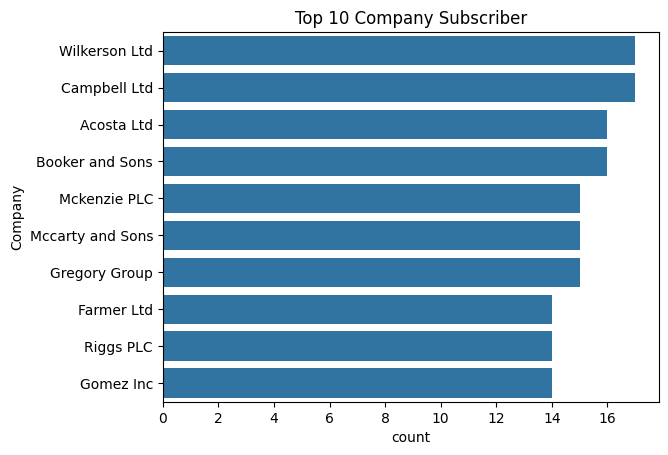

In [14]:
plot_top_n(df, 'Company', "Top 10 Company Subscriber")


--- Memory Profile for `plot_top_n` ---
Start memory   : 429.77 MB
End memory     : 431.77 MB
Peak (tracked) : 30.62 MB
Execution time : 0.14 sec
------------------------------------------


--- Memory Profile for `plot_top_company_by_type` ---
Start memory   : 389.66 MB
End memory     : 425.77 MB
Peak (tracked) : 0.00 MB
Execution time : 0.38 sec
------------------------------------------



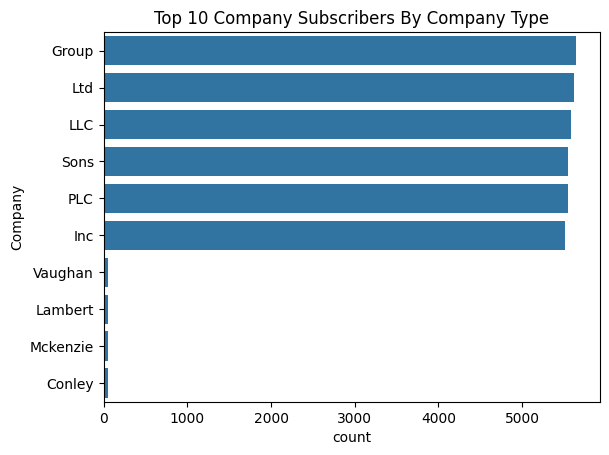

In [15]:
@profiler
def plot_top_company_by_type(src):
    company_suffix = src["Company"].str.split().apply(lambda x: x[-1])
    plot_top_n(company_suffix, title="Top 10 Company Subscribers By Company Type")

plot_top_company_by_type(df)

### Subscription Date

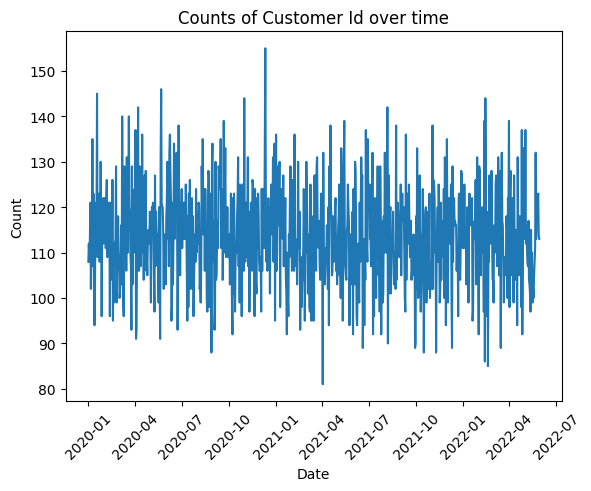


--- Memory Profile for `plot_counts_over_time` ---
Start memory   : 425.78 MB
End memory     : 425.95 MB
Peak (tracked) : 3.58 MB
Execution time : 0.33 sec
------------------------------------------



In [16]:
@profiler
def plot_counts_over_time(df: pd.DataFrame, date_col: str, count_col: str):
    # Ensure datetime
    df[date_col] = pd.to_datetime(df[date_col])

    # Aggregate counts per date
    df_counts = df.groupby(date_col)[count_col].count().reset_index()

    # Plot
    sns.lineplot(data=df_counts, x=date_col, y=count_col)
    plt.xticks(rotation=45)
    plt.xlabel("Date")
    plt.ylabel("Count")
    plt.title(f"Counts of {count_col} over time")
    plt.show()

plot_counts_over_time(df, "Subscription Date", "Customer Id")

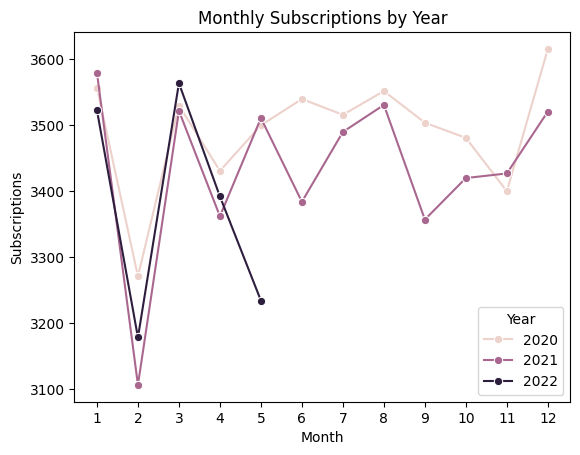


--- Memory Profile for `plot_subscriptions_monthly` ---
Start memory   : 426.03 MB
End memory     : 405.06 MB
Peak (tracked) : 6.71 MB
Execution time : 0.27 sec
------------------------------------------



In [17]:
@profiler
def plot_subscriptions_monthly(df: pd.DataFrame, date_col: str):
    df["Year"] = df[date_col].dt.year
    df["Month"] = df[date_col].dt.month
    
    monthly_counts = df.groupby(["Year", "Month"]).size().reset_index(name="Count")
    sns.lineplot(
        data=monthly_counts,
        x="Month",
        y="Count",
        hue="Year",      # separate line per year
        marker="o"       # dots on points (optional)
    )
    
    plt.xticks(range(1, 13))  # months 1–12
    plt.xlabel("Month")
    plt.ylabel("Subscriptions")
    plt.title("Monthly Subscriptions by Year")
    plt.show()

plot_subscriptions_monthly(df, "Subscription Date")

### Country


--- Memory Profile for `plot_top_n` ---
Start memory   : 405.64 MB
End memory     : 406.56 MB
Peak (tracked) : 10.97 MB
Execution time : 0.14 sec
------------------------------------------



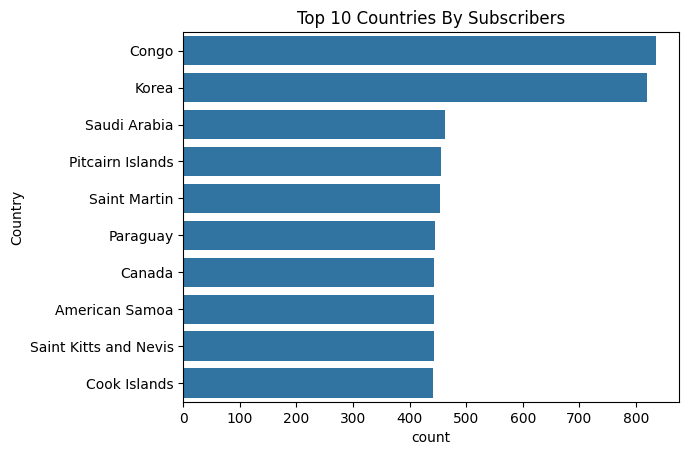

In [19]:
plot_top_n(df, "Country", title="Top 10 Countries By Subscribers")

### Phone Number

In [20]:
def plot_phone_number_pattern(df: pd.DataFrame, col: str):
    df['Phone Pattern'] = df[col].str.replace(r"\d", "d", regex=True)
    n = df['Phone Pattern'].nunique()
    plot_top_n(df, 'Phone Pattern', title=f"Count Top Phone Number Type ({col})", top=n)


--- Memory Profile for `plot_top_n` ---
Start memory   : 413.28 MB
End memory     : 420.53 MB
Peak (tracked) : 11.82 MB
Execution time : 0.17 sec
------------------------------------------



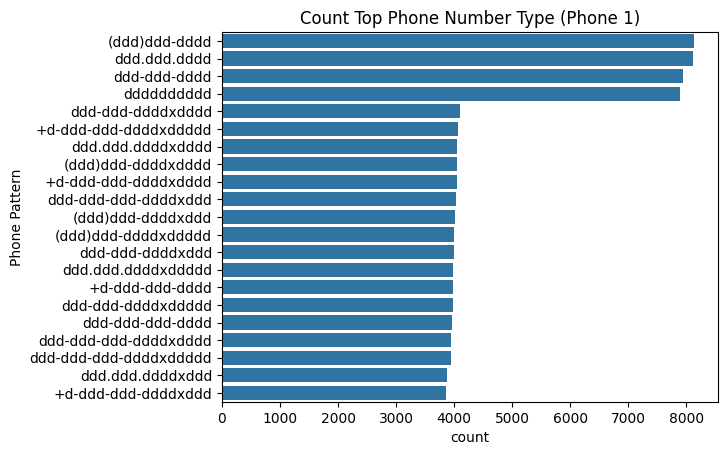

In [21]:
plot_phone_number_pattern(df, "Phone 1")


--- Memory Profile for `plot_top_n` ---
Start memory   : 427.78 MB
End memory     : 428.44 MB
Peak (tracked) : 11.81 MB
Execution time : 0.17 sec
------------------------------------------



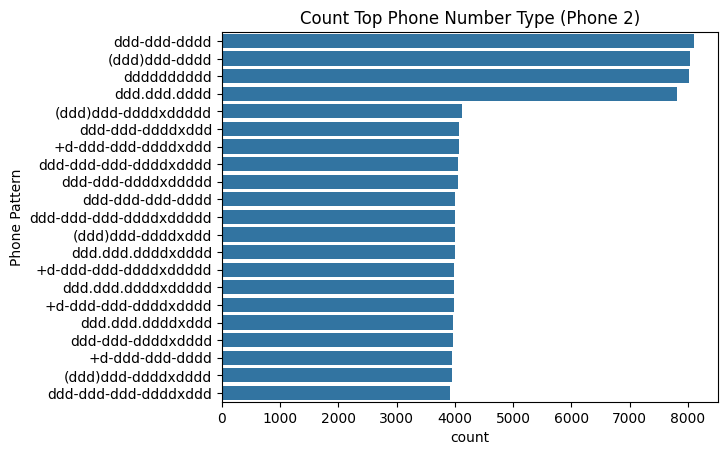

In [22]:
plot_phone_number_pattern(df, "Phone 2")

### Email

In [23]:
email_domain = df["Email"].str.split("@").apply(lambda x: x[-1])
email_domain.nunique()

38322


--- Memory Profile for `plot_top_n` ---
Start memory   : 448.75 MB
End memory     : 452.08 MB
Peak (tracked) : 11.27 MB
Execution time : 0.12 sec
------------------------------------------



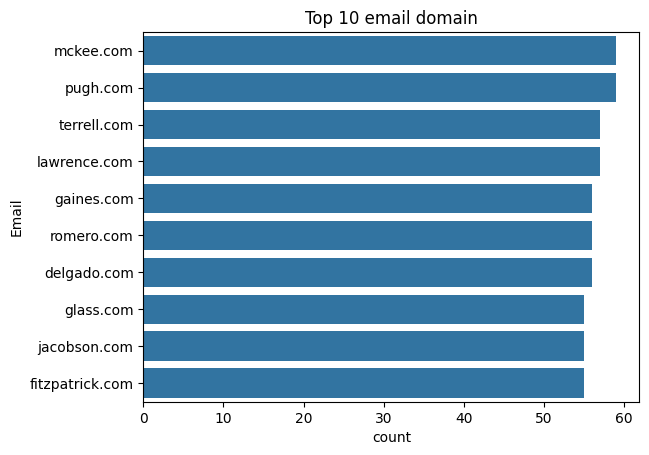

In [24]:
plot_top_n(email_domain, title="Top 10 email domain")